In [1]:
import warnings
import numpy as np

np.warnings = warnings

In [2]:
import os
import re
import scipy
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import networkit as nk
import torch_geometric as pyg
import matplotlib.pyplot as plt
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch_geometric.utils import add_self_loops, degree
from mst_clustering.cpp_adapters import SpanningForest
from torch_geometric.nn.conv import MessagePassing
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from typing import Union
from pathlib import Path
from tqdm import tqdm

sns.set_style('whitegrid')

%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
russian_dict = pd.read_csv('dictionaries-ru/russian_dictionary_1000.csv')

In [5]:
russian_dict['Unnamed: 0'].to_json('ru_all_words.json')

SVD dict head:

In [6]:
russian_dict.set_index('Unnamed: 0')

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
а,-7.238828,-2.765842,0.818670,0.193760,0.767979,1.771349,0.678688,-0.270946,0.190166,-0.098123,...,0.000704,-0.005281,0.004328,-0.005346,-0.002610,0.004824,0.004826,0.004336,0.000627,-0.003966
аа,-0.005475,0.000338,0.000048,-0.002703,0.002035,0.000340,0.001683,0.000432,0.001250,-0.000421,...,-0.000171,0.000079,-0.000288,0.000658,-0.000737,0.000701,-0.001004,-0.001264,0.002331,0.001401
ааа,-0.003853,-0.002275,0.000401,-0.001694,0.000614,0.000724,0.000343,0.001150,0.000346,0.000236,...,0.003522,-0.001168,-0.001599,0.000970,-0.004117,-0.002358,-0.001221,-0.001459,-0.001110,0.001622
аааа,-0.000967,0.000755,0.000221,-0.000003,0.001096,0.000026,-0.000380,0.000531,-0.000339,-0.001460,...,-0.000617,-0.000606,0.000494,0.000388,0.000138,-0.000329,0.000796,-0.001648,0.000412,-0.001076
ааааа,-0.000209,0.000228,0.000254,-0.000217,0.000376,-0.000034,0.000167,0.000103,0.000151,-0.000003,...,-0.000028,-0.000370,-0.000177,0.000001,0.000275,0.000092,0.000061,-0.000056,0.000282,0.000107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ящур,-0.001949,0.000153,-0.000588,-0.000376,0.002066,0.000990,-0.000517,-0.000178,0.000217,0.000103,...,0.000549,0.002732,-0.002561,0.000207,0.001084,-0.000415,-0.003887,-0.001911,-0.003515,-0.001309
яютъ,-0.000018,0.000068,0.000358,-0.000031,0.000062,-0.000083,-0.000015,-0.000117,0.000018,-0.000072,...,0.000022,-0.000007,0.000003,-0.000016,0.000011,-0.000009,-0.000003,-0.000013,0.000002,-0.000010
яющ,-0.000159,0.000715,0.002325,-0.000251,0.000521,-0.000279,-0.000056,-0.000277,0.000051,-0.000190,...,0.000075,-0.000077,-0.000083,0.000048,-0.000027,-0.000106,-0.000113,-0.000187,0.000102,-0.000086


In [7]:
lsm_matrix = np.load('mats-ru/data_vectorized_1000.npy')
sigma = np.load('mats-ru/sigma_1000.npy')
u = np.load('mats-ru/U_1000.npy')
vt = np.load('mats-ru/V_transposed_1000.npy')

In [8]:
def spanning_forest_to_pyg(
    dataset: Union[Path, np.ndarray], 
    batch_indices: Union[Path, np.ndarray],
    forest: Union[Path, SpanningForest]
) -> Union[torch.FloatTensor, torch.Tensor, torch.Tensor, torch.FloatTensor]:
    if isinstance(dataset, Path):
        dataset = np.load(dataset)
    
    if isinstance(batch_indices, Path):
        batch_indices = np.load(batch_indices)
        
    x = torch.from_numpy(dataset[batch_indices, :])
        
    if isinstance(forest, Path):
        numpy_forest = np.load(forest).T
        edges_inner_index = numpy_forest[:-1].astype(int)
        torch_edge_weight = torch.from_numpy(numpy_forest[-1])
    else:
        edges_dict = forest.get_all_edges()
        edges_inner_index = np.array(list(edges_dict.keys())).T.astype(int)
        torch_edge_weight = torch.FloatTensor(list(edges_dict.values())) 
        
    torch_edge_inner_index = torch.from_numpy(edges_inner_index).to(torch.int64)
    edges_outer_index = batch_indices[edges_inner_index]
    torch_edge_outer_index = torch.from_numpy(edges_outer_index).to(torch.int64)
    
    return x, torch_edge_inner_index, torch_edge_outer_index, torch_edge_weight

In [9]:
mst_path = Path('./trees-ru')
batches_path = Path('./batches-ru')

In [10]:
precomputed_mst_files = list(mst_path.glob('*.npy'))
precomputed_mst_files_numbers = list(map(
    lambda mst_file: re.sub(r'batch-(\d+)-mst', r'\1', mst_file.stem), precomputed_mst_files
))
indices_files = np.fromiter(map(
    lambda number: batches_path.joinpath(f'batch-{number}.npy'), precomputed_mst_files_numbers
), dtype=object)

In [11]:
indices_path = indices_files[0]

In [12]:
batch_indices = np.load(indices_path)

In [13]:
dataset = np.load('nofraglit-SVD-d=5-n=2.npy')

for mst_path, indices_path in tqdm(zip(precomputed_mst_files, indices_files)):
    x, edge_inner_index, edge_outer_index, edge_weight = spanning_forest_to_pyg(dataset, indices_path, mst_path)
    nk_edge_outer_index, nk_edge_weight = pyg_utils.to_undirected(edge_outer_index, edge_weight, num_nodes=dataset.shape[0], reduce='mean')

1it [00:02,  2.54s/it]


In [14]:
flags = torch.where(edge_weight > 1, 1, 0)
huge_weights_indices = torch.argsort(flags)[-torch.sum(flags):]
huge_edges = edge_inner_index[:, huge_weights_indices]
huge_edges_weights = edge_weight[huge_weights_indices]

In [15]:
sorted_huge_edges = huge_edges[:, torch.argsort(huge_edges_weights, descending=True)]

In [16]:
ru_dict_20 = np.load('BROKEN_russian_nofraglit_SVD_dict.npy', allow_pickle=True)
keys = np.array(list(ru_dict_20[()].keys()))
values = np.array(list(ru_dict_20[()].values()))
values = values[:, -5:]

batch_indices = np.load(f'batches-ru/batch-{precomputed_mst_files_numbers[0]}.npy')
batch = dataset[batch_indices, :]
standardized_batch = StandardScaler().fit_transform(batch)

In [17]:
def find_something_strange(index, ):
    first_point, second_point = batch[sorted_huge_edges[:, index]]

    fp_index_1st_part = np.sum(np.abs(values - first_point[:5]), axis=1).argmin()
    assert np.allclose(values[fp_index_1st_part], first_point[:5])

    fp_index_2nd_part = np.sum(np.abs(values - first_point[5:]), axis=1).argmin()
    assert np.allclose(values[fp_index_2nd_part], first_point[5:])

    sp_index_1st_part = np.sum(np.abs(values - second_point[:5]), axis=1).argmin()
    assert np.allclose(values[sp_index_1st_part], second_point[:5])

    sp_index_2nd_part = np.sum(np.abs(values - second_point[5:]), axis=1).argmin()
    assert np.allclose(values[sp_index_2nd_part], second_point[5:])
    
    r_distance = distance.euclidean(*standardized_batch[sorted_huge_edges[:, index]])
    word11 = keys[fp_index_1st_part]
    word12 = keys[fp_index_2nd_part]
    word21 = keys[sp_index_1st_part]
    word22 = keys[sp_index_2nd_part]
    
    return r_distance, word11, word12, word21, word22

In [19]:
from collections import Counter
from tqdm import tqdm

strange_words = Counter()
for index in tqdm(range(len(huge_edges_weights)), total=len(huge_edges_weights)):
    r_distance, word11, word12, word21, word22 = find_something_strange(index)
    strange_words.update((word11,))
    strange_words.update((word12,))
    strange_words.update((word21,))
    strange_words.update((word22,))

100%|██████████████████████████████████████████████████████████████████████████████| 3336/3336 [01:30<00:00, 37.05it/s]


In [90]:
norms = list()
for word in strange_words.keys():
    # norms.append(np.linalg.norm(ru_dict_20[()][word]))
    norms.append(np.mean(ru_dict_20[()][word]))
    # norms.append(np.abs(np.mean(ru_dict_20[()][word]) - np.quantile(ru_dict_20[()][word], 0.5)))
    # norms.append(np.std(ru_dict_20[()][word]))
norms = np.array(norms)
indices = np.argsort(norms)[::-1]
np.array(list(strange_words.keys()))[indices]

array(['не', 'быть', 'что', 'на', 'но', 'как', 'мой', 'же', 'этот', 'по',
       'так', 'свой', 'мочь', 'за', 'да', 'то', 'весь', 'бы', 'ни', 'из',
       'только', 'тот', 'для', 'дело', 'сам', 'знать', 'такой', 'ли',
       'если', 'какой', 'нет', 'год', 'от', 'или', 'твой', 'вот', 'уж',
       'еще', 'день', 'человек', 'время', 'где', 'когда', 'деньга',
       'жизнь', 'уже', 'бог', 'ведь', 'друг', 'отец', 'сказать', 'любовь',
       'душа', 'русский', 'хотеть', 'мир', 'народ', 'при', 'опять',
       'стать', 'сердце', 'его', 'слово', 'старик', 'сон', 'свет',
       'говорить', 'более', 'сей', 'взять', 'жена', 'око', 'думать',
       'общество', 'писатель', 'статья', 'ну', 'идти', 'ночь', 'пойти',
       'любить', 'ждать', 'над', 'забыть', 'большой', 'деревня',
       'счастие', 'также', 'мужик', 'смерть', 'лошадь', 'письмо',
       'написать', 'всегда', 'муж', 'глава', 'милый', 'изба', 'двор',
       'произведение', 'ах', 'учитель', 'пахарь', 'правильно', 'васъ',
       'продажный',

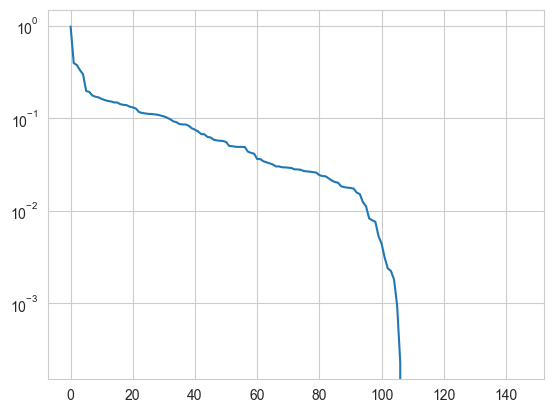

In [91]:
plt.plot(np.arange(len(norms)), norms[indices])
plt.yscale('log')

In [66]:
np.array(list(strange_words.keys()))[indices][:5]

array(['не', 'на', 'быть', 'что', 'как'], dtype='<U16')

In [67]:
np.array(list(strange_words.keys()))[indices][95:]

array(['окно', 'взять', 'издание', 'мир', 'более', 'письмо', 'такъ',
       'черный', 'произведение', 'всегда', 'писатель', 'печататься',
       'свет', 'друг', 'смерть', 'изъ', 'баба', 'том', 'изба', 'милый',
       'ах', 'сочинение', 'ставиться', 'сон', 'написать', 'деревня',
       'отъ', 'двор', 'общество', 'редактор', 'мнѣ', 'счастие', 'учитель',
       'рукопись', 'ждать', 'абзац', 'зачеркнуть', 'забыть', 'око',
       'былъ', 'также', 'всѣ', 'вотъ', 'глава', 'васъ', 'знак', 'себѣ',
       'безъ', 'правильно', 'пахарь', 'продажный'], dtype='<U16')

In [92]:
np.array(list(strange_words.keys()))[indices][5:95]

array(['как', 'мой', 'же', 'этот', 'по', 'так', 'свой', 'мочь', 'за',
       'да', 'то', 'весь', 'бы', 'ни', 'из', 'только', 'тот', 'для',
       'дело', 'сам', 'знать', 'такой', 'ли', 'если', 'какой', 'нет',
       'год', 'от', 'или', 'твой', 'вот', 'уж', 'еще', 'день', 'человек',
       'время', 'где', 'когда', 'деньга', 'жизнь', 'уже', 'бог', 'ведь',
       'друг', 'отец', 'сказать', 'любовь', 'душа', 'русский', 'хотеть',
       'мир', 'народ', 'при', 'опять', 'стать', 'сердце', 'его', 'слово',
       'старик', 'сон', 'свет', 'говорить', 'более', 'сей', 'взять',
       'жена', 'око', 'думать', 'общество', 'писатель', 'статья', 'ну',
       'идти', 'ночь', 'пойти', 'любить', 'ждать', 'над', 'забыть',
       'большой', 'деревня', 'счастие', 'также', 'мужик', 'смерть',
       'лошадь', 'письмо', 'написать', 'всегда', 'муж'], dtype='<U16')

In [74]:
norms[indices]

array([ 8.24727556e-01,  5.10984774e-01,  3.44780510e-01,  3.41988466e-01,
        2.62638457e-01,  1.84019899e-01,  1.83221583e-01,  1.70928257e-01,
        1.64489143e-01,  1.63198396e-01,  1.54575102e-01,  1.46459534e-01,
        1.44714448e-01,  1.34677772e-01,  1.31405861e-01,  1.22289337e-01,
        1.21609101e-01,  1.21060452e-01,  1.19534034e-01,  1.15123903e-01,
        1.11622061e-01,  1.11491789e-01,  1.10518096e-01,  1.06683341e-01,
        1.02589925e-01,  1.01987620e-01,  9.44902114e-02,  9.42639552e-02,
        9.37814986e-02,  9.30232941e-02,  9.12678247e-02,  8.85399942e-02,
        8.81594232e-02,  8.67668934e-02,  8.42669367e-02,  8.35899853e-02,
        8.19908359e-02,  8.17589711e-02,  7.97593333e-02,  7.25798853e-02,
        6.88275571e-02,  6.56142734e-02,  6.47403774e-02,  6.45880455e-02,
        6.40174746e-02,  6.38586435e-02,  6.06415902e-02,  5.32694050e-02,
        5.25275505e-02,  5.24765196e-02,  5.15080126e-02,  5.12100418e-02,
        4.97146297e-02,  

All strange words counts:

In [38]:
strange_words.most_common()

[('же', 339),
 ('тот', 286),
 ('ну', 274),
 ('нет', 248),
 ('быть', 229),
 ('для', 228),
 ('на', 227),
 ('не', 227),
 ('этот', 226),
 ('от', 224),
 ('душа', 223),
 ('что', 222),
 ('мой', 222),
 ('жизнь', 219),
 ('или', 217),
 ('но', 216),
 ('из', 216),
 ('весь', 216),
 ('человек', 216),
 ('по', 212),
 ('то', 212),
 ('въ', 211),
 ('да', 207),
 ('отец', 206),
 ('если', 206),
 ('сердце', 206),
 ('съ', 204),
 ('уж', 204),
 ('как', 201),
 ('какъ', 197),
 ('за', 197),
 ('ни', 197),
 ('говорить', 196),
 ('вот', 196),
 ('какой', 195),
 ('ведь', 195),
 ('сказать', 193),
 ('так', 193),
 ('свой', 190),
 ('мочь', 188),
 ('онъ', 187),
 ('его', 185),
 ('такъ', 182),
 ('любить', 182),
 ('къ', 175),
 ('любовь', 171),
 ('народ', 162),
 ('твой', 160),
 ('мужик', 160),
 ('рука', 158),
 ('знать', 149),
 ('пойти', 144),
 ('текст', 140),
 ('слово', 140),
 ('только', 131),
 ('русский', 128),
 ('когда', 124),
 ('голова', 112),
 ('день', 106),
 ('всегда', 105),
 ('стр', 101),
 ('такой', 100),
 ('хотеть', 99),


Garbage words:

In [19]:
garbage_keys = set([
    'же', 'тот', 'ну', 'нет', 'для', 'на', 'не', 'этот', 'от', 'что',
    'мой', 'или', 'но', 'из', 'весь', 'по', 'то', 'въ', 'да', 'если',
    'съ', 'уж', 'как', 'какъ', 'за', 'ни', 'вот', 'какой', 'ведь',
    'ведь', 'так', 'свой', 'онъ', 'его', 'такъ', 'къ', 'твой', 'стр',
    'изъ', 'бы', 'nbsp', 'lt', 'gt', 'мнѣ', 'всѣ', 'при', 'отъ', 'былъ',
    'еще', 'ее', 'где', 'ли', 'безъ', 'васъ'
])
np.array(garbage_keys)

array({'же', 'что', 'мнѣ', 'къ', 'свой', 'вот', 'бы', 'ли', 'въ', 'так', 'такъ', 'если', 'за', 'какъ', 'на', 'мой', 'то', 'lt', 'nbsp', 'но', 'съ', 'gt', 'былъ', 'ее', 'нет', 'ведь', 'из', 'изъ', 'как', 'васъ', 'уж', 'этот', 'стр', 'для', 'ни', 'его', 'при', 'от', 'или', 'твой', 'где', 'онъ', 'тот', 'какой', 'всѣ', 'ну', 'по', 'безъ', 'не', 'весь', 'да', 'отъ', 'еще'},
      dtype=object)

In [20]:
all_words_dict = ru_dict_20[()]
garbage_values = np.array([all_words_dict[key] for key in garbage_keys])
non_garbage_values = np.array([all_words_dict[key] for key in all_words_dict.keys() if key not in garbage_keys])

# Смотрим на пиксели

In [21]:
garbage_values = garbage_values[:, -20:][:, ::-1]

In [22]:
non_garbage_values = non_garbage_values[:, -20:][:, ::-1]

In [23]:
non_garbage_values_small = non_garbage_values[np.random.choice(np.arange(non_garbage_values.shape[0]), size=garbage_values.shape[0], replace=False)]
non_garbage_values_small = non_garbage_values_small[:, -20:][:, ::-1]

In [24]:
all_values = np.array(list(ru_dict_20[()].values()))[:, -20:][:, ::-1]

Всего четыре выборки:
1) garbage_values - мусорные слова, найденные алгоритмом
2) non_garbage_values_small - подвыборка из всех оставшихся (не мусорных) слов, размер которой равен размеру мусорных слов
3) non_garbage_values - слова из словаря, не вошедшие в список мусорных garbage_values
4) all_values - все слова из словаря

## Mean

In [28]:
heatmap_data = pd.DataFrame({
    'garbage_values_mean': np.mean(garbage_values, axis=0),
    'non_garbage_values_small_mean': np.mean(non_garbage_values_small, axis=0),
    'non_garbage_values_mean': np.mean(non_garbage_values, axis=0),
    'all_values_mean': np.mean(all_values, axis=0),
})

Компоненты эмбеддингов усредняются по словам в каждой выборке. Выглядит так, что абсолютные значения компонент мусорных слов в среднем сильно больше.

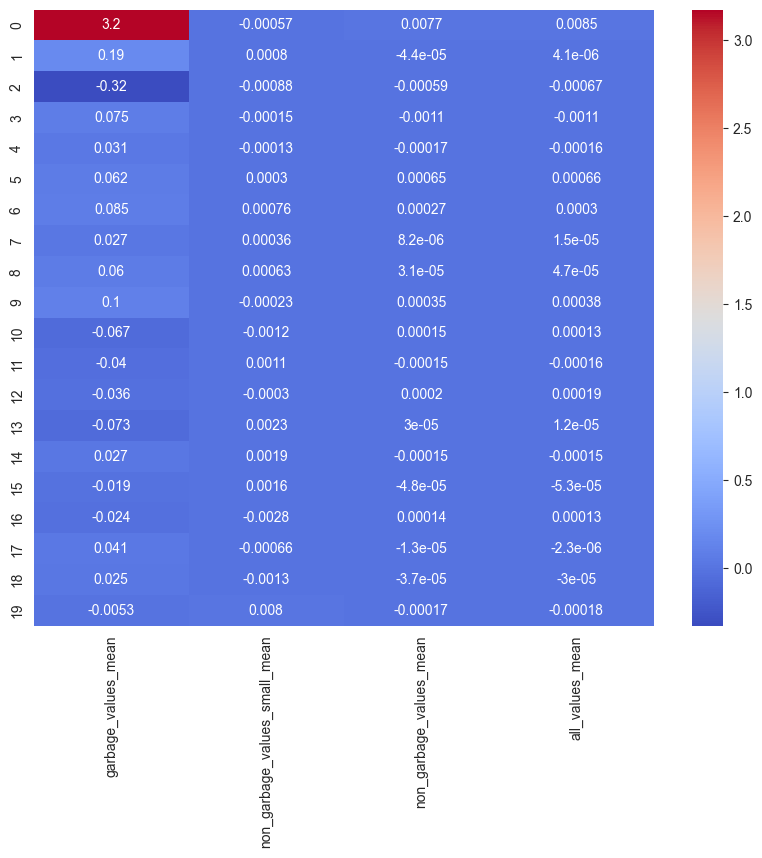

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [30]:
heatmap_data = pd.DataFrame({
    'garbage_values_mean': np.mean(garbage_values, axis=0)[1:],
    'non_garbage_values_small_mean': np.mean(non_garbage_values_small, axis=0)[1:],
    'non_garbage_values_mean': np.mean(non_garbage_values, axis=0)[1:],
    'all_values_mean': np.mean(all_values, axis=0)[1:],
})

Та же картинка, но без первой компоненты.

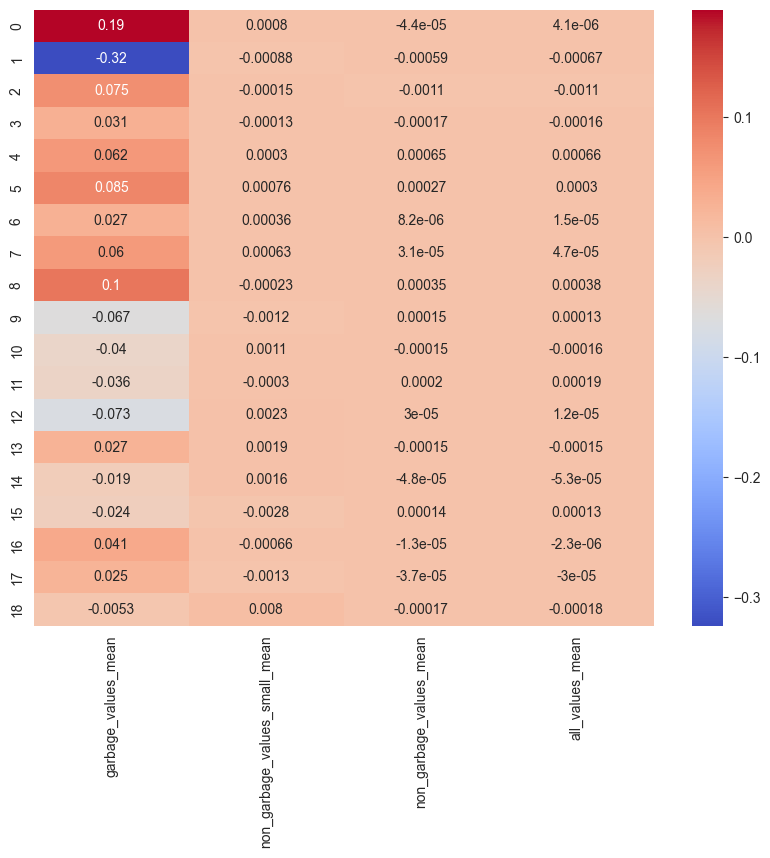

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

# STD

In [32]:
heatmap_data = pd.DataFrame({
    'garbage_values_std': np.std(garbage_values, axis=0),
    'non_garbage_values_small_std': np.std(non_garbage_values_small, axis=0),
    'non_garbage_values_std': np.std(non_garbage_values, axis=0),
    'all_values_std': np.std(all_values, axis=0),
})

Стандартное отклонение компонент эмбеддингов по словам в каждой выборке. Аналогично пердыдущему пункту, большая дисперсия характерна только для мусорных слов (для малой выборки немусорных такой картины не наблюдается).

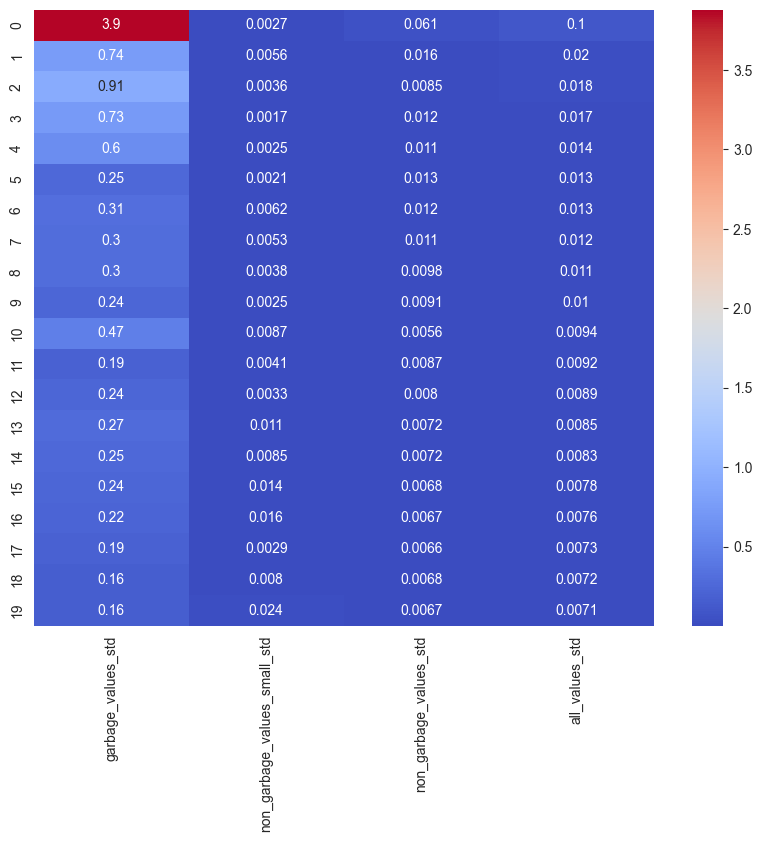

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [34]:
heatmap_data = pd.DataFrame({
    'garbage_values_std': np.std(garbage_values, axis=0)[1:],
    'non_garbage_values_small_std': np.std(non_garbage_values_small, axis=0)[1:],
    'non_garbage_values_std': np.std(non_garbage_values, axis=0)[1:],
    'all_values_std': np.std(all_values, axis=0)[1:],
})

Та же картинка, но без первой компоненты.

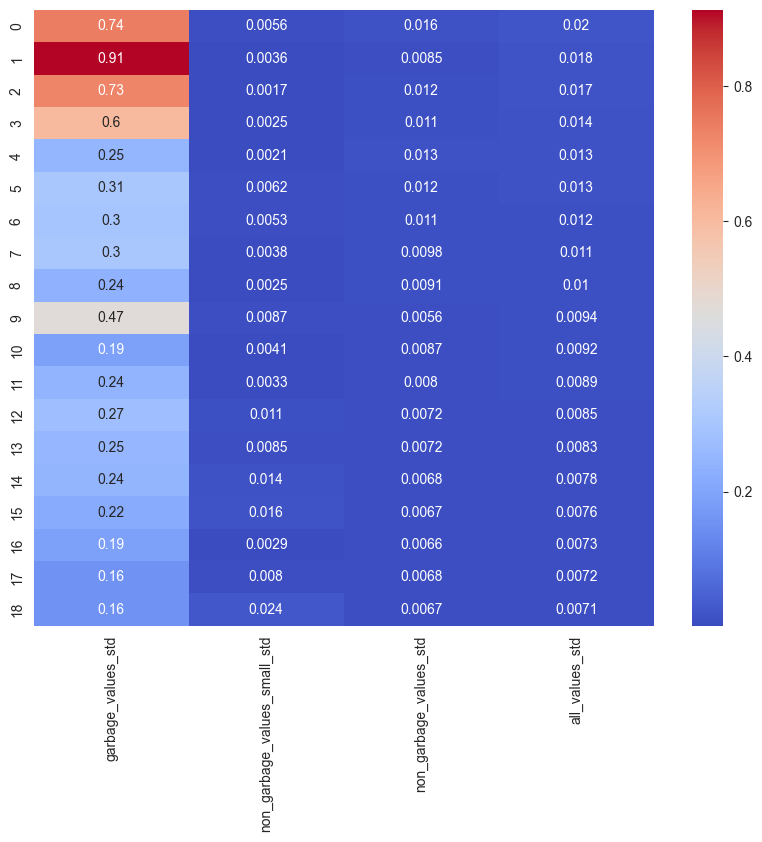

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

## MAX

In [36]:
heatmap_data = pd.DataFrame({
    'garbage_values_max': np.max(garbage_values, axis=0),
    'non_garbage_values_small_max': np.max(non_garbage_values_small, axis=0),
    'non_garbage_values_max': np.max(non_garbage_values, axis=0),
    'all_values_max': np.max(all_values, axis=0),
})

Максимальное значение по каждой компоненте среди слов в выборках. Тут уже можно предполагать, что автоматический алгоритм на MST нашёл не весь мусор.

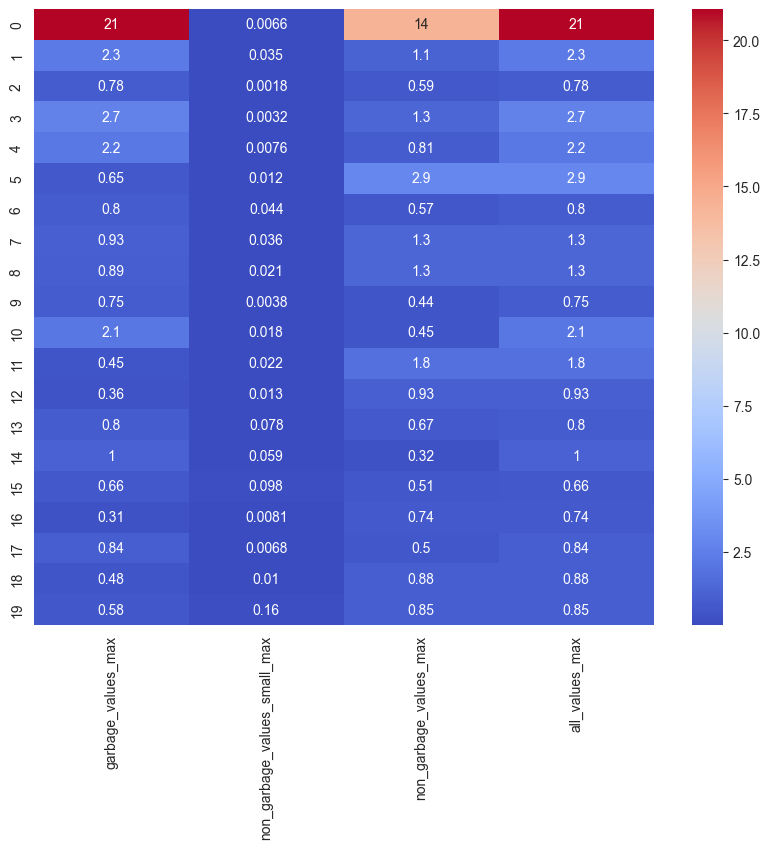

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [38]:
heatmap_data = pd.DataFrame({
    'garbage_values_max': np.max(garbage_values, axis=0)[1:],
    'non_garbage_values_small_max': np.max(non_garbage_values_small, axis=0)[1:],
    'non_garbage_values_max': np.max(non_garbage_values, axis=0)[1:],
    'all_values_max': np.max(all_values, axis=0)[1:],
})

Та же картинка, но без первой компоненты.

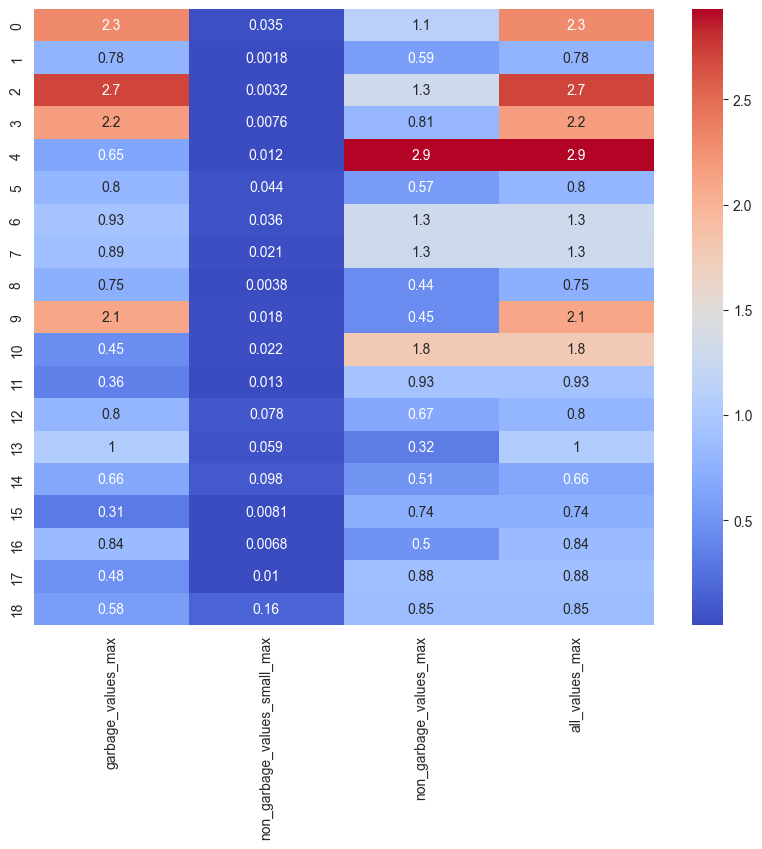

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

## MIN

In [40]:
heatmap_data = pd.DataFrame({
    'garbage_values_min': np.min(garbage_values, axis=0),
    'non_garbage_values_small_min': np.min(non_garbage_values_small, axis=0),
    'non_garbage_values_min': np.min(non_garbage_values, axis=0),
    'all_values_min': np.min(all_values, axis=0),
})

Аналогично предыдущему пункту, но значения берутся минимальные.

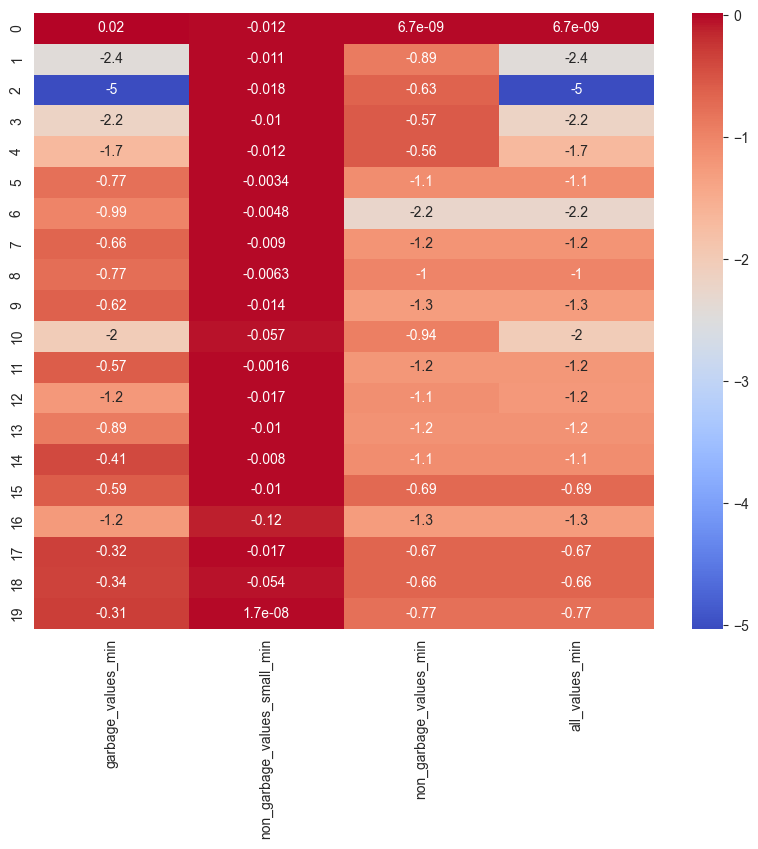

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

## NORMS

Отношение нормы Фробениуса матриц выборок к их числу строк (слов). Кажется, можно определять мусорные слова по норме вектора.

In [42]:
norm_data = pd.Series({
    'garbage_values_f-norm-scaled': np.linalg.norm(garbage_values, ord='fro') / garbage_values.shape[0],
    'non_garbage_values_small_f-norm-scaled': np.linalg.norm(non_garbage_values_small, ord='fro') / non_garbage_values_small.shape[0],
    'non_garbage_values_f-norm-scaled': np.linalg.norm(non_garbage_values, ord='fro') / non_garbage_values.shape[0],
    'all_values_f-norm-scaled': np.linalg.norm(all_values, ord='fro') / all_values.shape[0],
})
norm_data

garbage_values_f-norm              0.734960
non_garbage_values_small_f-norm    0.005598
non_garbage_values_f-norm          0.000161
all_values_f-norm                  0.000247
dtype: float64

Отношение ядерной нормы матриц выборок к их числу строк (слов). Интерпретация?

In [43]:
norm_data = pd.Series({
    'garbage_values_nuc-norm-scaled': np.linalg.norm(garbage_values, ord='nuc') / garbage_values.shape[0],
    'non_garbage_values_small_nuc-norm-scaled': np.linalg.norm(non_garbage_values_small, ord='nuc') / non_garbage_values_small.shape[0],
    'non_garbage_values_nuc-norm-scaled': np.linalg.norm(non_garbage_values, ord='nuc') / non_garbage_values.shape[0],
    'all_values_nuc-norm-scaled': np.linalg.norm(all_values, ord='nuc') / all_values.shape[0],
})
norm_data

garbage_values_nuc-norm              1.515811
non_garbage_values_small_nuc-norm    0.010952
non_garbage_values_nuc-norm          0.000497
all_values_nuc-norm                  0.000679
dtype: float64

Максимальные сингулярные значения матриц выборок. Интерпретация?

In [44]:
norm_data = pd.Series({
    'garbage_values_max-singular-scaled': np.linalg.norm(garbage_values, ord=2),
    'non_garbage_values_small_max-singular-scaled': np.linalg.norm(non_garbage_values_small, ord=2),
    'non_garbage_values_max-singular-scaled': np.linalg.norm(non_garbage_values, ord=2),
    'all_values_max-singular-scaled': np.linalg.norm(all_values, ord=2),
})
norm_data

garbage_values_max-singular              36.527508
non_garbage_values_small_max-singular     0.268325
non_garbage_values_max-singular          27.963472
all_values_max-singular                  45.913305
dtype: float64

Минимальные ненуевые сингулярные значения матриц выборок. Число обусловенности для мусорных слов огромно. Интерпретация?

In [45]:
norm_data = pd.Series({
    'garbage_values_min-singular-scaled': np.linalg.norm(garbage_values, ord=-2),
    'non_garbage_values_small_min-singular-scaled': np.linalg.norm(non_garbage_values_small, ord=-2),
    'non_garbage_values_min-singular-scaled': np.linalg.norm(non_garbage_values, ord=-2),
    'all_values_min-singular-scaled': np.linalg.norm(all_values, ord=-2),
})
norm_data

garbage_values_min-singular              0.018690
non_garbage_values_small_min-singular    0.001291
non_garbage_values_min-singular          1.518727
all_values_min-singular                  3.239919
dtype: float64

# SVD spectrum

In [46]:
from sklearn.utils.extmath import randomized_svd

In [47]:
heatmap_data = pd.DataFrame({
    'garbage_values_eig': randomized_svd(garbage_values, 30)[1],
    'non_garbage_values_small_eig': randomized_svd(non_garbage_values_small, 30)[1],
    'non_garbage_values_eig': randomized_svd(non_garbage_values, 30)[1],
    'all_values_eig': randomized_svd(all_values, 30)[1],
})

Спектр сингулярных значений для матриц каждой выборки.

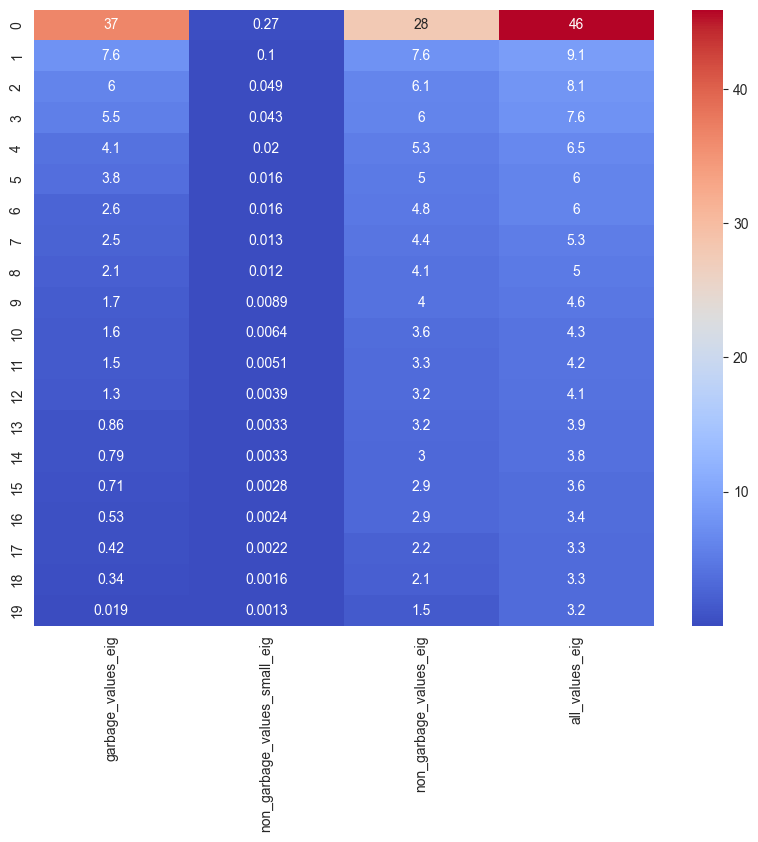

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

## Статистики по LSM-matrix

In [27]:
index = dict()
for pos, word in enumerate(russian_dict['Unnamed: 0'].values):
    index[word] = pos 

In [33]:
garbage_indices = [index[key] for key in garbage_keys if key in index]
garbage_mask = np.zeros(lsm_matrix.shape[1]).astype(bool)
garbage_mask[garbage_indices] = True

In [34]:
lsm_garbage = lsm_matrix[:, garbage_mask].T
lsm_non_garbage = lsm_matrix[:, ~garbage_mask].T

In [37]:
lsm_non_garbage_small = lsm_non_garbage[np.random.choice(np.arange(lsm_non_garbage.shape[0]), size=lsm_garbage.shape[0], replace=False)]

LSM-матрица: в строках слова, в столбцах документы.

### MEAN

In [46]:
temp1 = np.sort(np.mean(lsm_garbage, axis=0))
temp2 = np.sort(np.mean(lsm_non_garbage_small, axis=0))
temp3 = np.sort(np.mean(lsm_non_garbage, axis=0))
temp4 = np.sort(np.mean(lsm_matrix.T, axis=0))

In [47]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_mean': temp1[-20:][::-1],
    'lsm_non_garbage_small_mean': temp2[-20:][::-1],
    'lsm_non_garbage_mean': temp3[-20:][::-1],
    'lsm_matrix_mean': temp4[-20:][::-1],
})

Усреднение компонент по словам в каждой выборке, сортировка по убыванию.

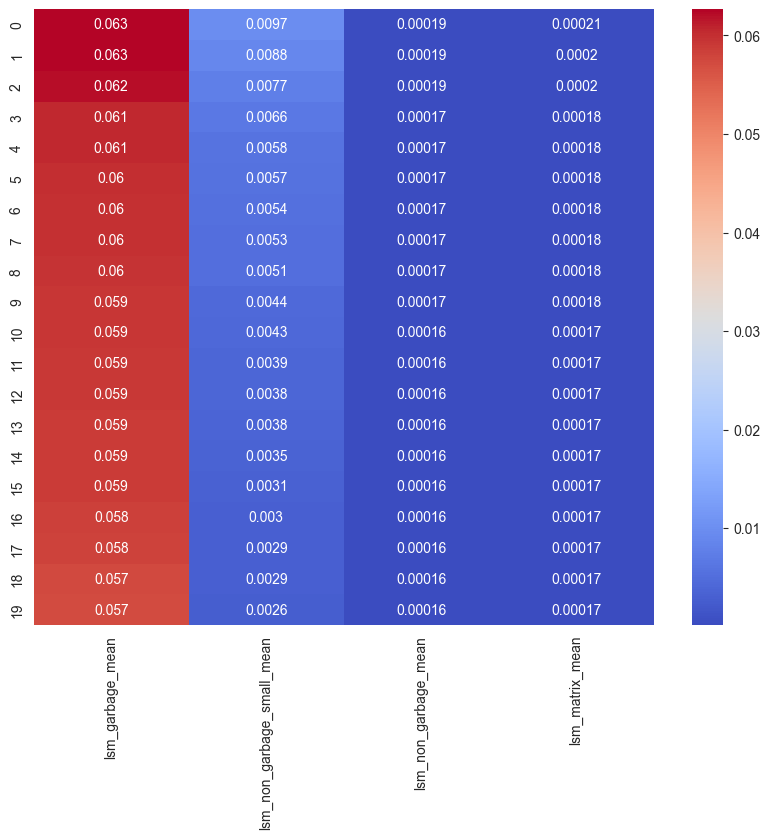

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [55]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_mean': temp1[temp1 > 0][:10],
    'lsm_non_garbage_small_mean': temp2[temp2 > 0][:10],
    'lsm_non_garbage_mean': temp3[temp3 > 0][:10],
    'lsm_matrix_mean': temp4[temp4 > 0][:10],
})

Усреднение компонент по словам в каждой выборке, сортировка по возрастанию.

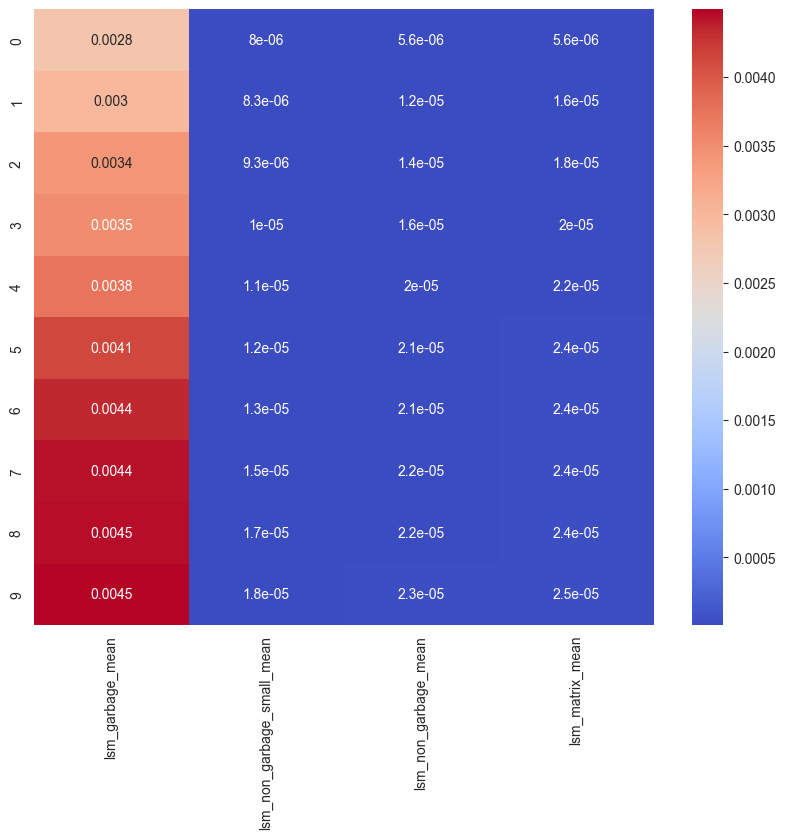

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

**Агргегация по документам**

In [75]:
temp1 = np.sort(np.mean(lsm_garbage, axis=1))
temp2 = np.sort(np.mean(lsm_non_garbage_small, axis=1))
temp3 = np.sort(np.mean(lsm_non_garbage, axis=1))
temp4 = np.sort(np.mean(lsm_matrix.T, axis=1))

In [76]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_mean': temp1[-20:][::-1],
    'lsm_non_garbage_small_mean': temp2[-20:][::-1],
    'lsm_non_garbage_mean': temp3[-20:][::-1],
    'lsm_matrix_mean': temp4[-20:][::-1],
})

Усреднение компонент по документам в каждой выборке, сортировка по убыванию.

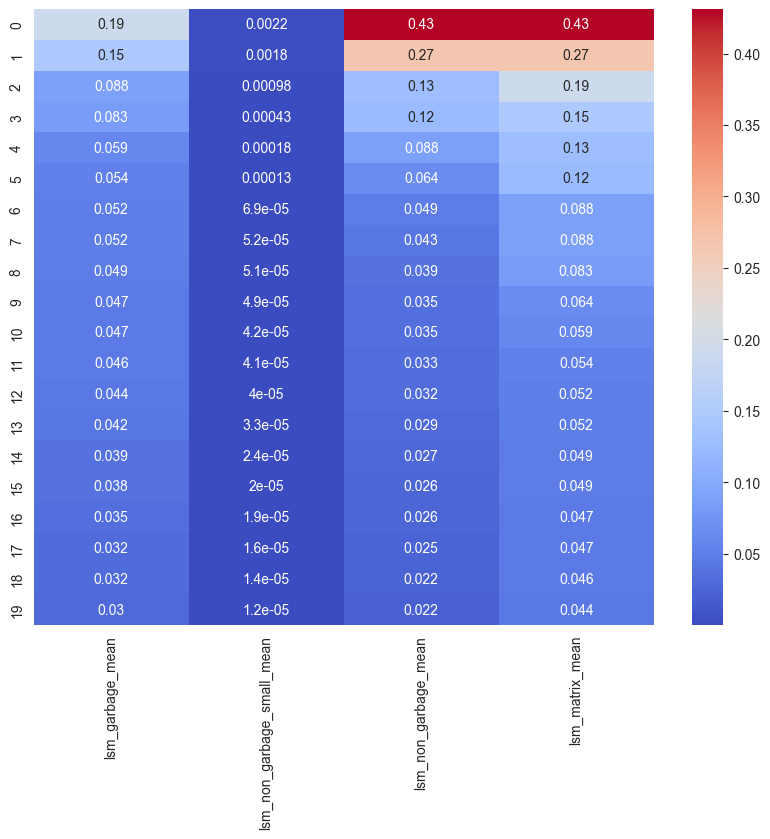

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [78]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_mean': temp1[temp1 > 0][:10],
    'lsm_non_garbage_small_mean': temp2[temp2 > 0][:10],
    'lsm_non_garbage_mean': temp3[temp3 > 0][:10],
    'lsm_matrix_mean': temp4[temp4 > 0][:10],
})

Усреднение компонент по документам в каждой выборке, сортировка по возрастанию.

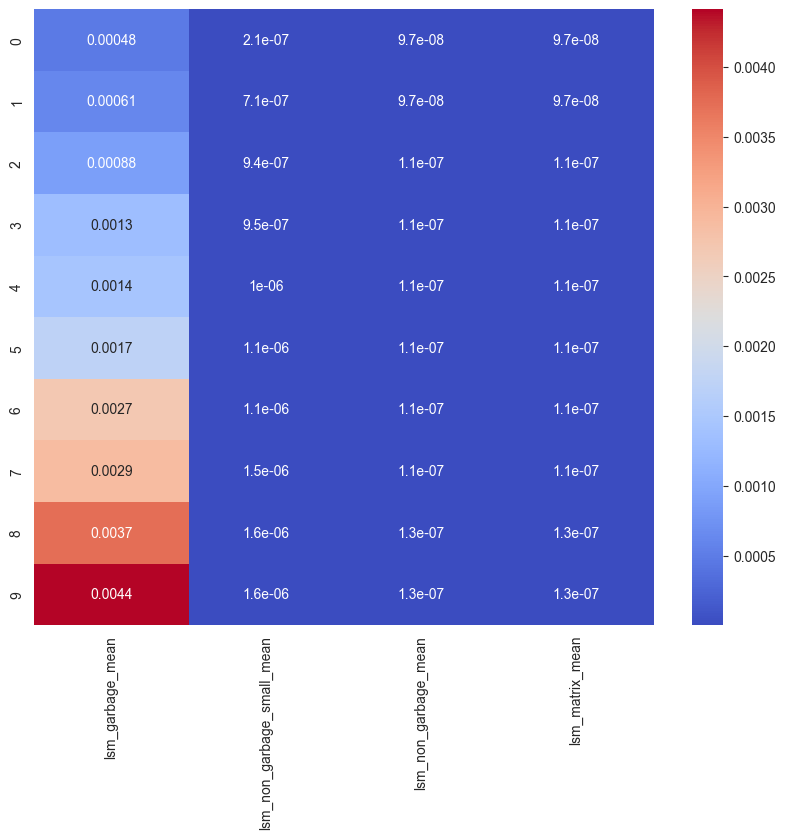

In [79]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

### STD

In [59]:
temp1 = np.sort(np.std(lsm_garbage, axis=0))
temp2 = np.sort(np.std(lsm_non_garbage_small, axis=0))
temp3 = np.sort(np.std(lsm_non_garbage, axis=0))
temp4 = np.sort(np.std(lsm_matrix.T, axis=0))

In [60]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_std': temp1[-20:][::-1],
    'lsm_non_garbage_small_std': temp2[-20:][::-1],
    'lsm_non_garbage_std': temp3[-20:][::-1],
    'lsm_matrix_std': temp4[-20:][::-1],
})

Стандартное отклонение компонент по словам в каждой выборке, сортировка по убыванию.

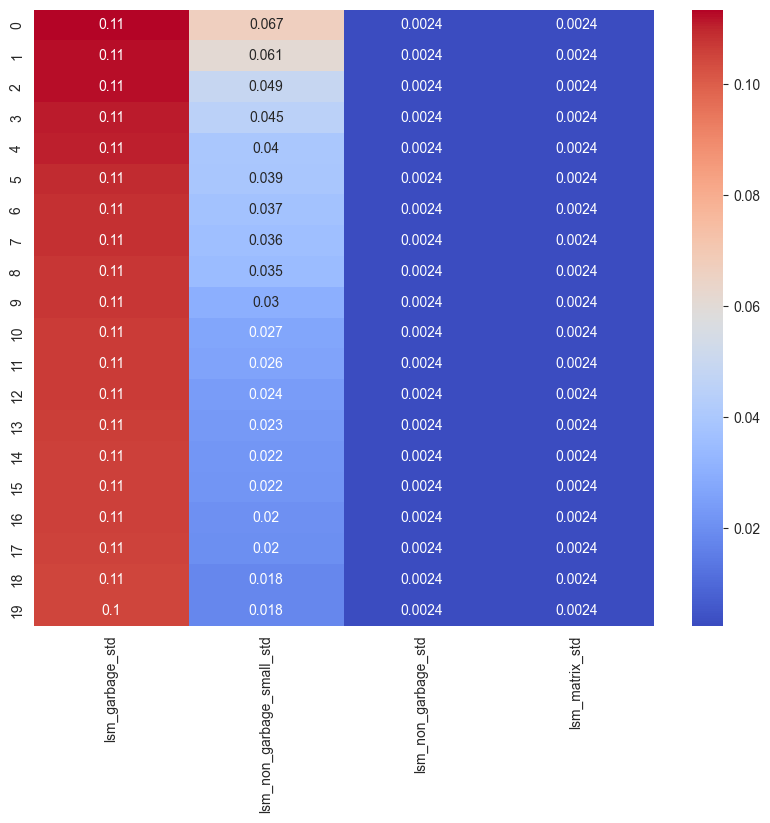

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [64]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_std': temp1[temp1 > 0][:10],
    'lsm_non_garbage_small_std': temp2[temp2 > 0][:10],
    'lsm_non_garbage_std': temp3[temp3 > 0][:10],
    'lsm_matrix_std': temp4[temp4 > 0][:10],
})

Стандартное отклонение компонент по словам в каждой выборке, сортировка по возрастанию.

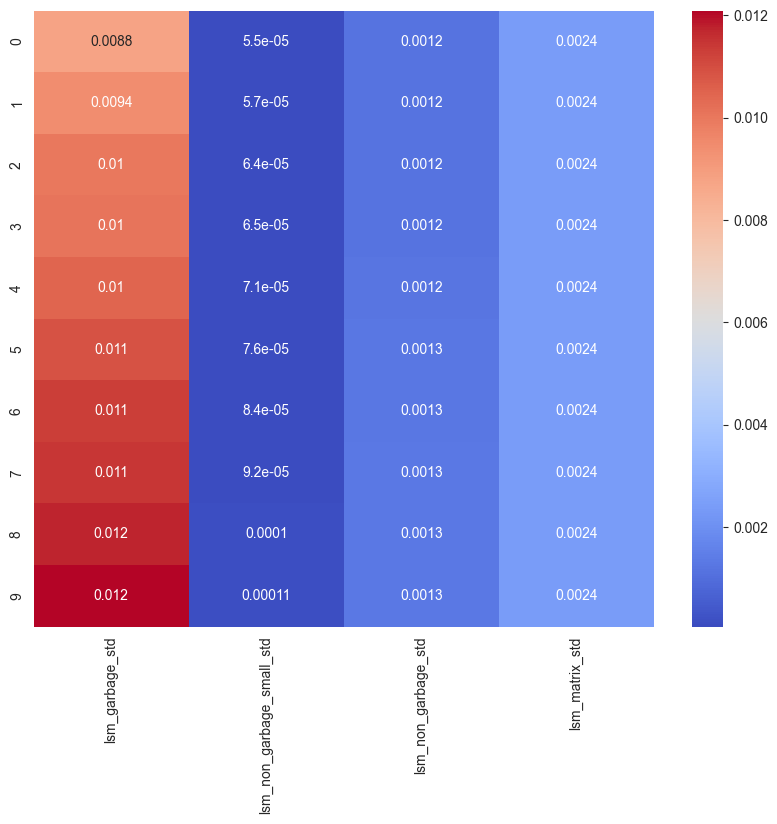

In [65]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

**Агрегация по документам**

In [68]:
temp1 = np.sort(np.std(lsm_garbage, axis=1))
temp2 = np.sort(np.std(lsm_non_garbage_small, axis=1))
temp3 = np.sort(np.std(lsm_non_garbage, axis=1))
temp4 = np.sort(np.std(lsm_matrix.T, axis=1))

In [69]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_std': temp1[-20:][::-1],
    'lsm_non_garbage_small_std': temp2[-20:][::-1],
    'lsm_non_garbage_std': temp3[-20:][::-1],
    'lsm_matrix_std': temp4[-20:][::-1],
})

Стандартное отклонение компонент по документам в каждой выборке, сортировка по убыванию.

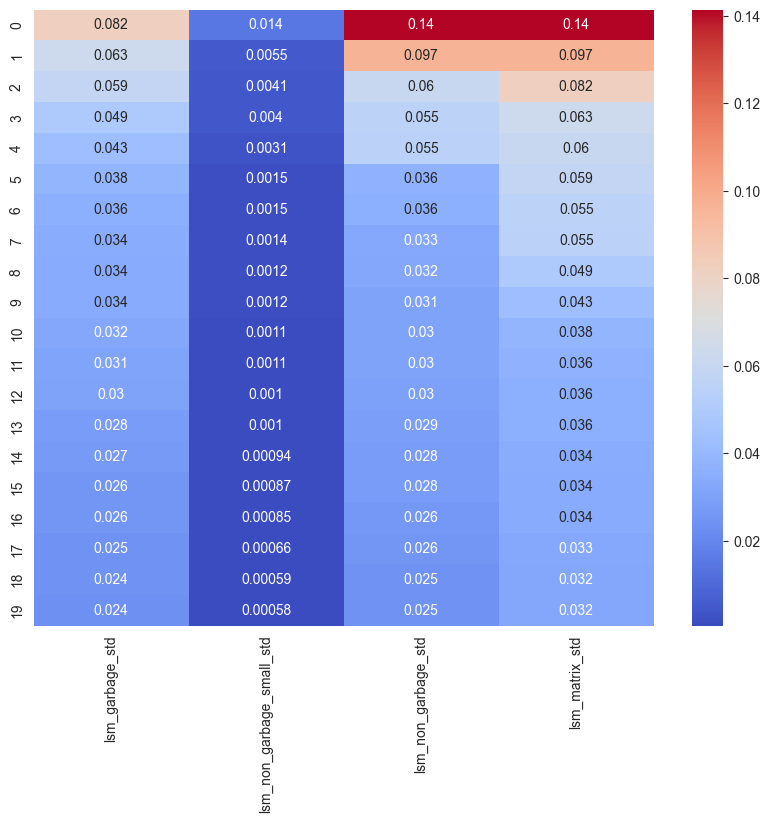

In [70]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

In [71]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_std': temp1[temp1 > 0][:10],
    'lsm_non_garbage_small_std': temp2[temp2 > 0][:10],
    'lsm_non_garbage_std': temp3[temp3 > 0][:10],
    'lsm_matrix_std': temp4[temp4 > 0][:10],
})

Стандартное отклонение компонент по документам в каждой выборке, сортировка по возрастанию.

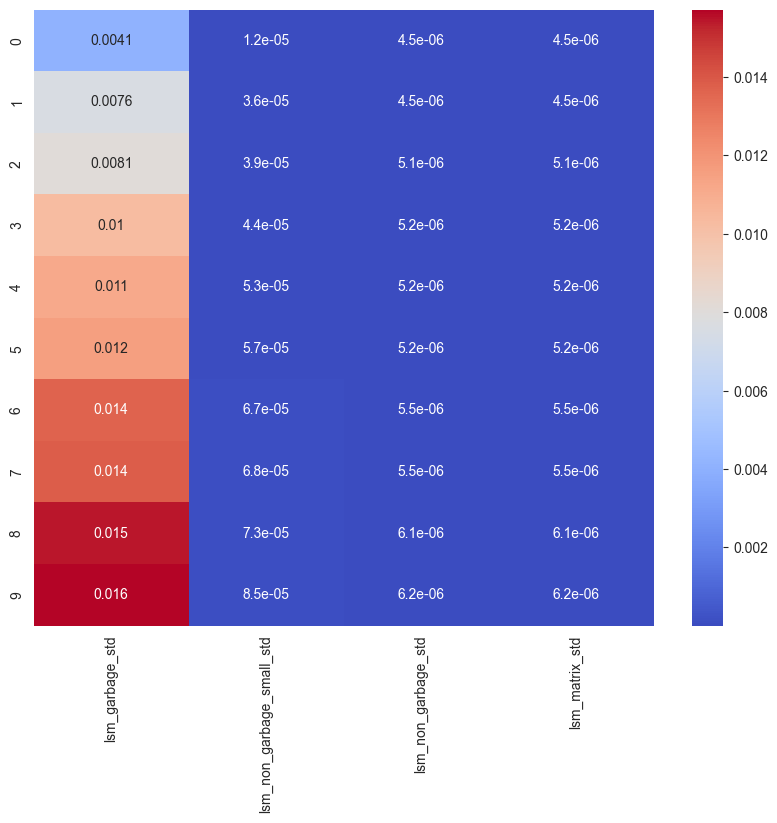

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

### MAX

In [82]:
temp1 = np.sort(np.max(lsm_garbage, axis=0))
temp2 = np.sort(np.max(lsm_non_garbage_small, axis=0))
temp3 = np.sort(np.max(lsm_non_garbage, axis=0))
temp4 = np.sort(np.max(lsm_matrix.T, axis=0))

In [83]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_max': temp1[-20:][::-1],
    'lsm_non_garbage_small_max': temp2[-20:][::-1],
    'lsm_non_garbage_max': temp3[-20:][::-1],
    'lsm_matrix_max': temp4[-20:][::-1],
})

Максимальные значения компонент по словам в каждой выборке, сортировка по убыванию.

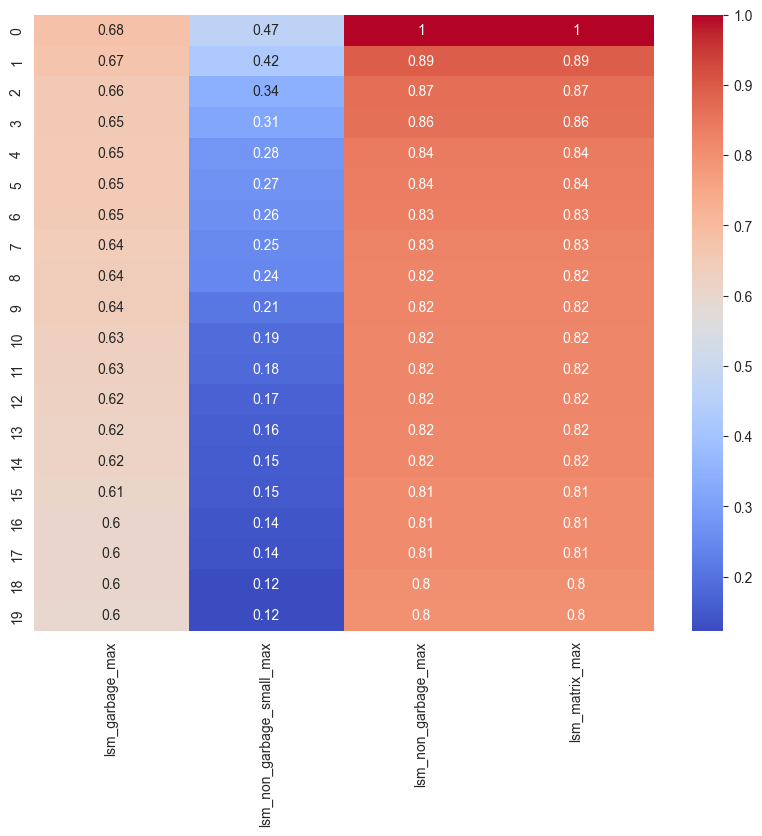

In [84]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

**Агрегация по документам**

In [86]:
temp1 = np.sort(np.max(lsm_garbage, axis=1))
temp2 = np.sort(np.max(lsm_non_garbage_small, axis=1))
temp3 = np.sort(np.max(lsm_non_garbage, axis=1))
temp4 = np.sort(np.max(lsm_matrix.T, axis=1))

Максимальные значения компонент по документам в каждой выборке, сортировка по убыванию.

In [91]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_max': temp1[-20:][::-1],
    'lsm_non_garbage_small_max': temp2[-20:][::-1],
    'lsm_non_garbage_max': temp3[-20:][::-1],
    'lsm_matrix_max': temp4[-20:][::-1],
})

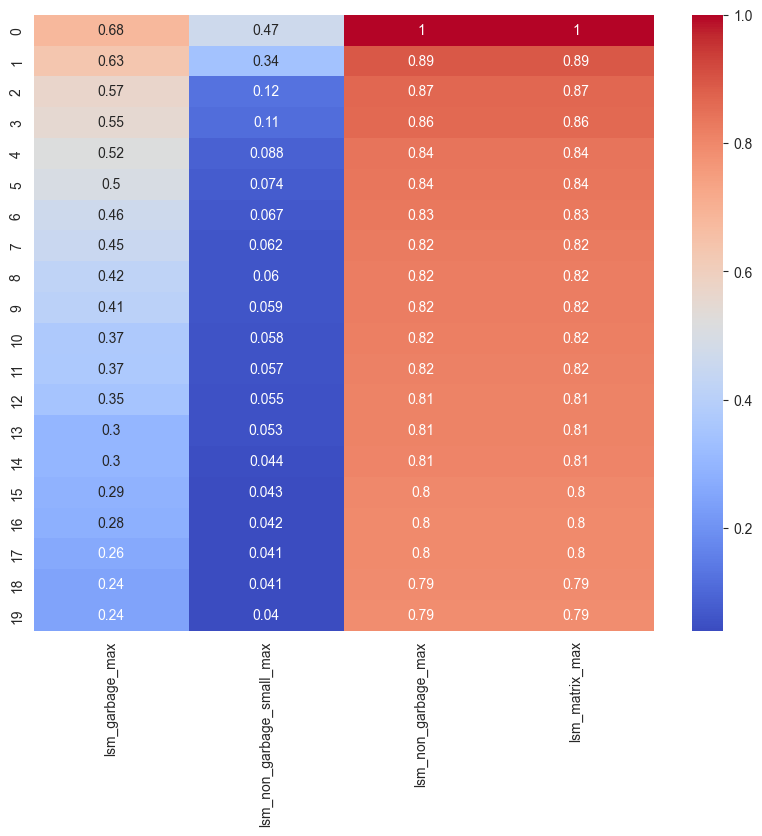

In [92]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

## MIN

In [ ]:
temp1 = np.sort(np.min(lsm_garbage, axis=0))
temp2 = np.sort(np.min(lsm_non_garbage_small, axis=0))
temp3 = np.sort(np.min(lsm_non_garbage, axis=0))
temp4 = np.sort(np.min(lsm_matrix.T, axis=0))

In [94]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_max': temp1[-20:][::-1],
    'lsm_non_garbage_small_max': temp2[-20:][::-1],
    'lsm_non_garbage_max': temp3[-20:][::-1],
    'lsm_matrix_max': temp4[-20:][::-1],
})

Минимальные значения компонент по словам в каждой выборке, сортировка по убыванию.

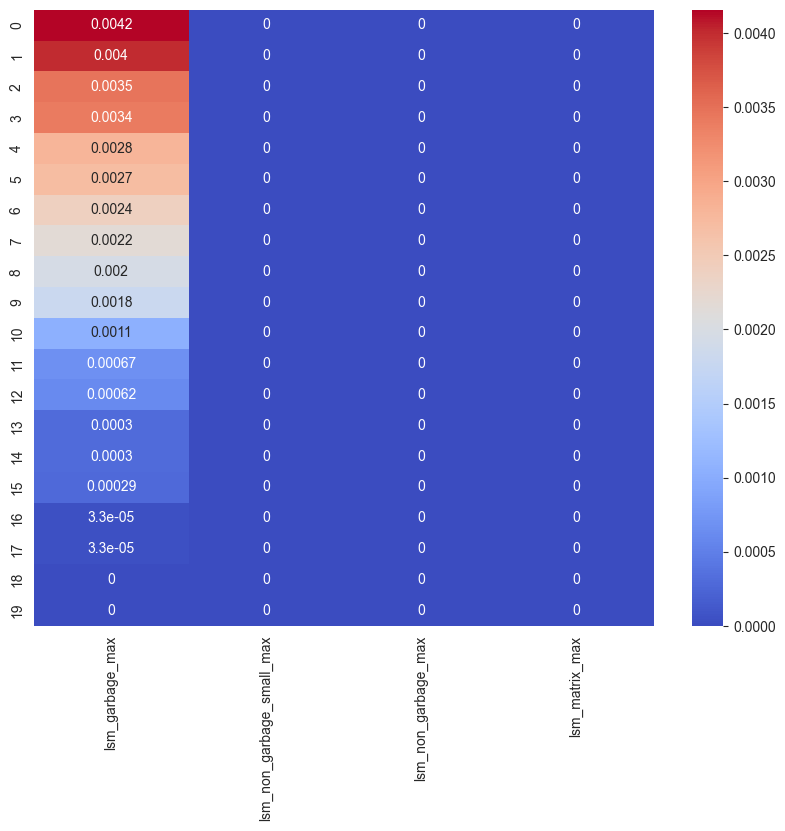

In [95]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

Агрегация по документам

In [ ]:
temp1 = np.sort(np.min(lsm_garbage, axis=1))
temp2 = np.sort(np.min(lsm_non_garbage_small, axis=1))
temp3 = np.sort(np.min(lsm_non_garbage, axis=1))
temp4 = np.sort(np.min(lsm_matrix.T, axis=1))

In [99]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_max': temp1[-1:][::-1],
    'lsm_non_garbage_small_max': temp2[-1:][::-1],
    'lsm_non_garbage_max': temp3[-1:][::-1],
    'lsm_matrix_max': temp4[-1:][::-1],
})

Минимальные значения компонент по документам в каждой выборке, сортировка по убыванию.

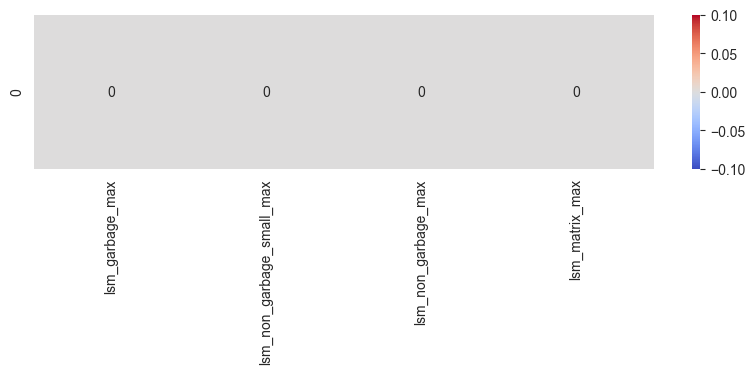

In [102]:
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

### NORMS

Отношение нормы Фробениуса lsm-матриц к их числу строк (слов).

In [105]:
norm_data = pd.Series({
    'lsm_garbage_f-norm-scaled': np.linalg.norm(lsm_garbage, ord='fro') / lsm_garbage.shape[0],
    'lsm_non_garbage_small_f-norm-scaled': np.linalg.norm(lsm_non_garbage_small, ord='fro') / lsm_non_garbage_small.shape[0],
    'lsm_non_garbage_f-norm-scaled': np.linalg.norm(lsm_non_garbage, ord='fro') / lsm_non_garbage.shape[0],
    'lsm_matrix_f-norm-scaled': np.linalg.norm(lsm_matrix.T, ord='fro') / lsm_matrix.T.shape[0],
})
norm_data

lsm_garbage_f-norm-scaled              0.651662
lsm_non_garbage_small_f-norm-scaled    0.029320
lsm_non_garbage_f-norm-scaled          0.000415
lsm_matrix_f-norm-scaled               0.000451
dtype: float64

Отношение ядерной нормы lsm-матриц к их числу строк (слов).

In [118]:
norm_data = pd.Series({
    'lsm_garbage_nuc-norm-scaled': np.linalg.norm(lsm_garbage, ord='nuc') / lsm_garbage.shape[0],
    'lsm_non_garbage_small_nuc-norm-scaled': np.linalg.norm(lsm_non_garbage_small, ord='nuc') / lsm_non_garbage_small.shape[0],
    'lsm_non_garbage_nuc-norm-scaled': np.linalg.norm(lsm_non_garbage, ord='nuc') / lsm_non_garbage.shape[0],
    'lsm_matrix_nuc-norm-scaled': np.linalg.norm(lsm_matrix.T, ord='nuc') / lsm_matrix.T.shape[0],
})
norm_data

lsm_garbage_nuc-norm-scaled              2.141967
lsm_non_garbage_small_nuc-norm-scaled    0.088218
lsm_non_garbage_nuc-norm-scaled          0.020504
lsm_matrix_nuc-norm-scaled               0.020820
dtype: float64

Максимальные сингулярные значения lsm-матриц.

In [119]:
norm_data = pd.Series({
    'lsm_garbage_max-singular': randomized_svd(lsm_garbage, 1)[1],
    'lsm_non_garbage_small_max-singular': randomized_svd(lsm_non_garbage_small, 1)[1],
    'lsm_non_garbage_max-singular': randomized_svd(lsm_non_garbage, 1)[1],
    'lsm_matrix_max-singular': randomized_svd(lsm_matrix.T, 1)[1],
})
norm_data

lsm_garbage_max-singular              [28.101512803957704]
lsm_non_garbage_small_max-singular    [1.1668945361333654]
lsm_non_garbage_max-singular          [49.606134191994876]
lsm_matrix_max-singular                [56.80095554097994]
dtype: object

### SVD spectrum

In [172]:
from sklearn.utils.extmath import randomized_svd

In [190]:
heatmap_data = pd.DataFrame({
    'lsm_garbage_eig': randomized_svd(lsm_garbage, 30)[1],
    'lsm_non_garbage_small_eig': randomized_svd(lsm_non_garbage_small, 30)[1],
    'lsm_non_garbage_eig': randomized_svd(lsm_non_garbage, 30)[1],
    'lsm_matrix_eig': randomized_svd(lsm_matrix.T, 30)[1],
})

Малая часть сингулярного спектра lsm-матриц.

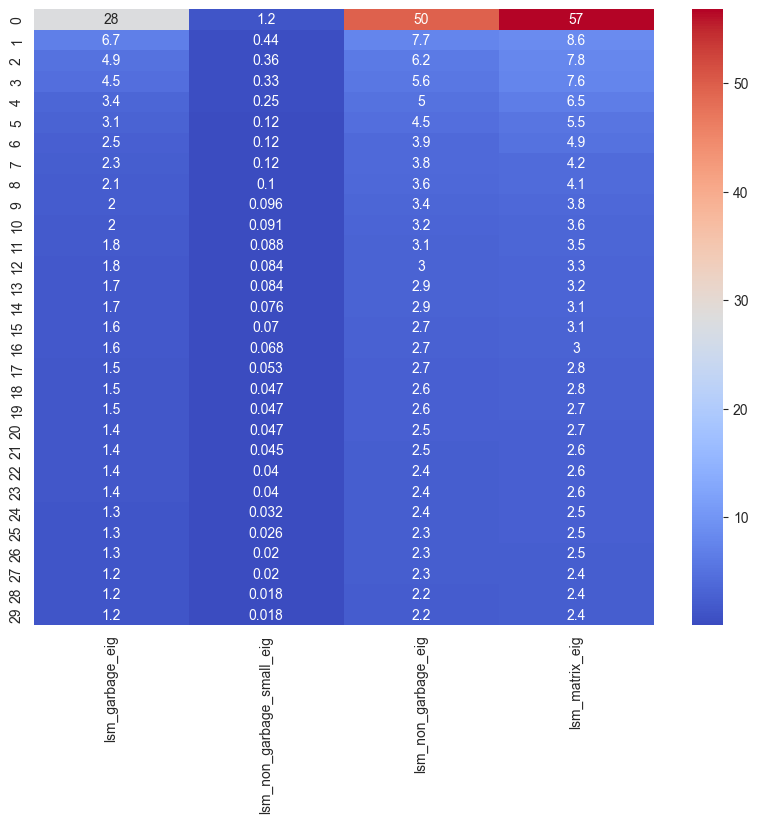

In [191]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.show()

# Всякие графовые штуки

## networkit graph

In [134]:
G = pyg_utils.to_networkit(nk_edge_outer_index, nk_edge_weight, num_nodes=dataset.shape[0], directed=False)

## Центральность

TODO

## Кастомная метрика

In [39]:
min_weights = np.ones(nk_edge_outer_index.max() + 1) * np.inf
mean_weights = np.zeros(nk_edge_outer_index.max() + 1)
max_weights = np.ones(nk_edge_outer_index.max() + 1) * -1

def fill_min_max_edges(node, other_node, edge_weight, edge_id):
    global min_weights, max_weights
    
    mean_weights[node] = mean_weights[node] + edge_weight
    mean_weights[other_node] = mean_weights[other_node] + edge_weight
    
    if edge_weight < min_weights[node]:
        min_weights[node] = edge_weight
        
    if edge_weight > max_weights[node]:
        max_weights[node] = edge_weight
        
    if edge_weight < min_weights[other_node]:
        min_weights[other_node] = edge_weight
        
    if edge_weight > max_weights[other_node]:
        max_weights[other_node] = edge_weight
        
G.forEdges(fill_min_max_edges)

In [40]:
degrees = pyg_utils.degree(nk_edge_outer_index.flatten()).numpy()
mean_weights = (mean_weights * 2) / degrees
metric_values = (mean_weights - min_weights) / (max_weights - min_weights + 1e-32)

C:\Users\User\AppData\Local\Temp\ipykernel_19092\2030663682.py:2: RuntimeWarning: invalid value encountered in divide
  mean_weights = (mean_weights * 2) / degrees


In [90]:
x_metric = torch.from_numpy(metric_values[batch_indices])
x_node_norm = torch.linalg.norm(x, dim=1, ord=2)

sort_indices = torch.argsort(x_metric)

x_metric = x_metric[sort_indices]
x_node_norm = ((x_node_norm[sort_indices] - x_node_norm[sort_indices].min()) / (x_node_norm[sort_indices].max() - x_node_norm[sort_indices].min())) * x_metric.max()

In [94]:
tck1 = interpolate.splrep(np.arange(sort_indices.shape[0]), x_node_norm.numpy(), s=0, k=3) 
tck2 = interpolate.splrep(np.arange(sort_indices.shape[0]), x_metric.numpy(), s=0, k=3) 

In [97]:
x_new = np.linspace(0, sort_indices.shape[0] - 1, 1000000)

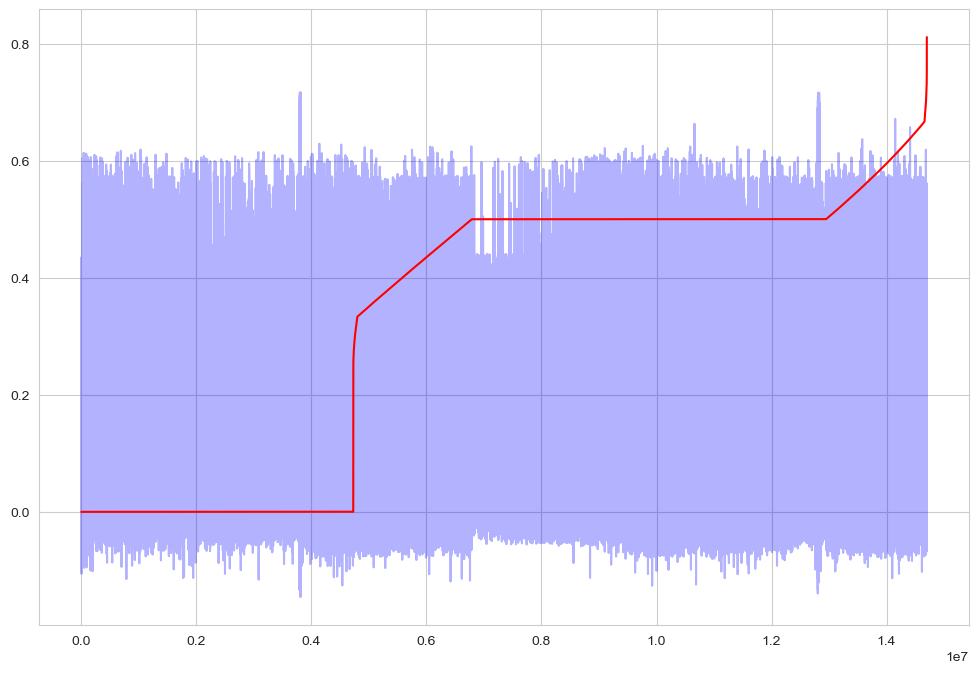

In [98]:
plt.figure(figsize=(12, 8))

plt.plot(x_new, interpolate.BSpline(*tck1)(x_new), 'b', alpha=0.3)
plt.plot(x_new, interpolate.BSpline(*tck2)(x_new), 'r')

plt.show()

# Прототипирование

In [18]:
words_means = np.log10(np.mean(values, axis=1))
sort_indices = np.argsort(words_means)[::-1]
finite_indices = np.isfinite(words_means[sort_indices])
sorted_finite_means = words_means[sort_indices][finite_indices]

C:\Users\User\AppData\Local\Temp\ipykernel_12256\827384873.py:1: RuntimeWarning: invalid value encountered in log10
  words_means = np.log10(np.mean(values, axis=1))


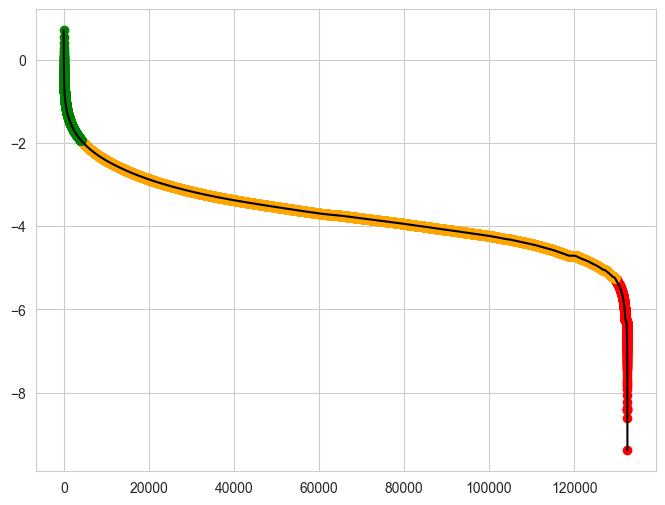

In [19]:
from scipy.interpolate import UnivariateSpline

x = np.arange(sorted_finite_means.size)
f = UnivariateSpline(x, sorted_finite_means, k=3, s=0.3)
df = f.derivative()

cutting_condition = np.abs(df(x)) > 1e-4 * np.max(np.abs(df(x)))
mean_pos = int(np.mean(x))
left_bound = np.searchsorted(~cutting_condition[:mean_pos], False, side='right')
right_bound = mean_pos + np.searchsorted(cutting_condition[mean_pos:], True)

mask = np.zeros(x.shape).astype(bool)
main_words_mask = mask.copy()
main_words_mask[:left_bound] = True
absolute_garbage_mask = mask.copy()
absolute_garbage_mask[right_bound:] = True
optional_words_mask = ~(main_words_mask | absolute_garbage_mask)

plt.figure(figsize=(8, 6))
plt.scatter(x[absolute_garbage_mask], f(x[absolute_garbage_mask]), c='r')
plt.scatter(x[optional_words_mask], f(x[optional_words_mask]), c='orange')
plt.scatter(x[main_words_mask], f(x[main_words_mask]), c='g')
plt.plot(x, f(x), c='black')
plt.show()

In [20]:
items_to_show = 50

In [23]:
main_candidates = keys[sort_indices][finite_indices][main_words_mask]
print(main_candidates[:items_to_show])
print(main_candidates[-items_to_show:])
pd.Series(main_candidates).to_json('ru_main_words.txt', force_ascii=False, orient='records')

['не' 'быть' 'что' 'как' 'но' 'на' 'мой' 'так' 'свой' 'этот' 'весь' 'мочь'
 'же' 'человек' 'бы' 'говорить' 'знать' 'только' 'сказать' 'то' 'да' 'тот'
 'такой' 'за' 'от' 'по' 'для' 'сам' 'какой' 'жизнь' 'если' 'ни' 'нет' 'из'
 'когда' 'еще' 'или' 'другой' 'хотеть' 'вот' 'дело' 'очень' 'ли' 'любить'
 'наш' 'его' 'даже' 'чтобы' 'ваш' 'слово']
['порочный' 'славянин' 'пьяница' 'развратить' 'уход' 'состав' 'подражание'
 'отзываться' 'выработать' 'упрямый' 'щадить' 'дожить' 'установление'
 'кровавый' 'затея' 'бедняжка' 'укор' 'село' 'меняться' 'адский' 'деловой'
 'выучить' 'каторга' 'трон' 'двоюродный' 'пьянство' 'умолкнуть' 'ковер'
 'внезапно' 'побежать' 'последовательный' 'растеряться' 'тетрадка'
 'смешивать' 'украшение' 'сновидение' 'пощечина' 'оправдываться'
 'приучить' 'упорный' 'европеец' 'приниматься' 'унылый' 'воспитанница'
 'царствовать' 'гостить' 'раздражить' 'опоздать' 'унизительный' 'ручаться']


In [24]:
optional_candidates = keys[sort_indices][finite_indices][optional_words_mask]
print(optional_candidates[:items_to_show])
print(optional_candidates[-items_to_show:])
pd.Series(optional_candidates).to_json('ru_optional_words.txt', force_ascii=False, orient='records')

['заметьте' 'чувственный' 'клеопатра' 'неужто' 'питаться' 'поссориться'
 'недостаточный' 'герцогиня' 'беспомощный' 'прим' 'словарь'
 'возмутительный' 'иезуит' 'неправильный' 'задумчивость' 'нажить'
 'браслет' 'аббат' 'отправляться' 'склад' 'миновать' 'обещаться' 'пара'
 'темперамент' 'неопытный' 'невежда' 'навестить' 'паче' 'интимный'
 'прибегать' 'сечь' 'медицинский' 'фактический' 'вопреки' 'безнадежный'
 'вложить' 'решимость' 'бремя' 'коих' 'совестный' 'ужель' 'подтверждать'
 'романист' 'население' 'занимательный' 'отложить' 'обряд' 'утомить'
 'анархист' 'увеличение']
['tristesse' 'zwischen' 'перебранка' 'подрались' 'раскормленных'
 'разжалованы' 'присыхать' 'задул' 'минутво' 'серых' 'водоочистительный'
 'barber' 'эмансипатор' 'пьют' 'полустанция' 'зарока' 'любимся' 'фурманов'
 'eagle' 'огарками' 'класной' 'растрепка' 'обернувшаяся' 'древяный'
 'учительность' 'ледящий' 'ально' 'apporté' 'convention' 'покойницкая'
 'возлежание' 'грамотейница' 'capitulation' 'далечить' 'асмодеи'
 'форм

In [25]:
garbage_candidates = np.hstack((
    keys[sort_indices][finite_indices][absolute_garbage_mask],
    keys[sort_indices][~finite_indices]
))
print(garbage_candidates[:items_to_show])
print(garbage_candidates[-items_to_show:])
pd.Series(garbage_candidates).to_json('ru_garbage_candidates.txt', force_ascii=False, orient='records')

['attraction' 'лицеистик' 'noisy' 'выкормив' 'капри' 'стекая' 'комичен'
 'угадал' 'паросский' 'блеянием' 'притворнее' 'rocroi' 'жался' 'припустит'
 'eloquent' 'просоние' 'прикрикнет' 'подметены' 'рогдай' 'незаменимость'
 'вороненок' 'подзубривать' 'offenses' 'ородский' 'городовое' 'постелют'
 'vitals' 'создашь' 'отвыкнешь' 'pet' 'unite' 'урсула' 'милейшего'
 'мигающие' 'неспособною' 'поправлено' 'потачки' 'prognosis' 'talks'
 'христородица' 'каплюжник' 'away' 'забитее' 'декабра' 'approbation'
 'состраданіе' 'convalescent' 'питьецо' 'атаев' 'увс']
['вздымались' 'вздымалась' 'свешивая' 'берегахъ' 'береговой' 'столпиться'
 'utility' 'utterance' 'usurp' 'береговслышен' 'вздыбиться' 'utopian'
 'utensils' 'свешать' 'свечные' 'свешивать' 'usury' 'береговбросать'
 'столпами' 'смучиться' 'utter' 'usurpation' 'usurped' 'свешивались'
 'utilize' 'столпление' 'utterances' 'вздуют' 'береговыхна' 'вздымается'
 'uttered' 'блѣднымъ' 'смушка' 'свеяв' 'utopia' 'вздымает' 'usual'
 'вздыбив' 'берегамчернел